# Focus Binary Classification

## Introduction

As Brain Computer Interface technology continues to reach the mainstream, it would be very interesting to develop a device that is able to capture a user's neural state, particularly a focus state. Utilizing a metric for focus can be essential for many people as it can help the user gain insights into how their activities affect their focus level throughout the day or what environments make someone more focused. Neurable has created a first-generation device like this and we can assume that it will become more accurate and efficient as years pass and new models get developed. This project is my exposure to the field of neural data analysis as it pertains to focus classification.

## Methodology

The research experiment was as follows. I utilized an OpenBCI Ultracortex IV 16-channel headset and a Cyton+Daisy board. I gathered 15 minutes total of 'resting' data where I just looked at a wall. Then I gathered 15 minutes total of 'focus' data where I read different research articles on Brain Computer Interfaces.

## Code

### Import

In [53]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objs as go
import numpy as np
import pandas as pd
import time
import math
from brainflow.board_shim import BoardShim, BrainFlowInputParams
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.signal import butter, filtfilt
from scipy.signal import welch

app = dash.Dash(__name__)

rest1 = pd.read_csv('Rest_326.txt', sep=',', skiprows=4)
rest2 = pd.read_csv('Rest_419.txt', sep=',', skiprows=4)
rest3 = pd.read_csv('Rest_425.txt', sep=',', skiprows=4)
focus1 = pd.read_csv('Focus_326.txt', sep=',', skiprows=4)
focus2 = pd.read_csv('Focus_425.txt', sep=',', skiprows=4)
rest1_original = rest1
rest1 = rest1.iloc[:, 1:9]
rest2 = rest2.iloc[:, 1:9]
rest3 = rest3.iloc[:, 1:9]
rest = pd.concat([rest1, rest2, rest3], axis=0)
focus1 = focus1.iloc[:, 1:9]
focus2 = focus2.iloc[:, 1:9]
focus = pd.concat([focus1, focus2], axis=0)

datasets = [rest, focus]

In [100]:
datasets[0]

,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7
0,-12336.330096,-9949.856693,-23118.185773,-34290.459369,-30306.909121,-27583.773742,-19681.761525,-20357.164187
1,-24862.046523,-20080.293129,-47057.574637,-65494.165181,-61139.732437,-57319.796958,-40135.932283,-42007.443846
2,-24356.695933,-19715.244438,-48294.073140,-72709.554161,-59682.041071,-55677.010796,-41374.956533,-42256.464631
3,-24911.108602,-20109.663321,-46624.531940,-64810.492374,-61298.519230,-57148.157912,-39733.220903,-41657.437880
4,-24310.114898,-19703.733290,-48672.488174,-73236.943571,-59556.692488,-55879.361138,-41744.833201,-42578.642676
...,...,...,...,...,...,...,...,...
37942,6629.415647,-24599.480581,-75301.887131,-82999.671459,-64449.265832,-60826.673904,-73478.141246,-68015.732529
37943,6816.298582,-24506.206752,-75225.868848,-85068.101891,-65879.486904,-61945.825749,-73822.805145,-68132.855670
37944,6625.235871,-24582.582662,-75158.232469,-83607.884778,-64548.373467,-60826.249221,-73379.212425,-67896.933007
37945,6794.527983,-24553.659505,-75402.537036,-84437.939160,-65783.329699,-61974.681851,-73947.282010,-68289.831971


Let's take a look at our focus and resting data:

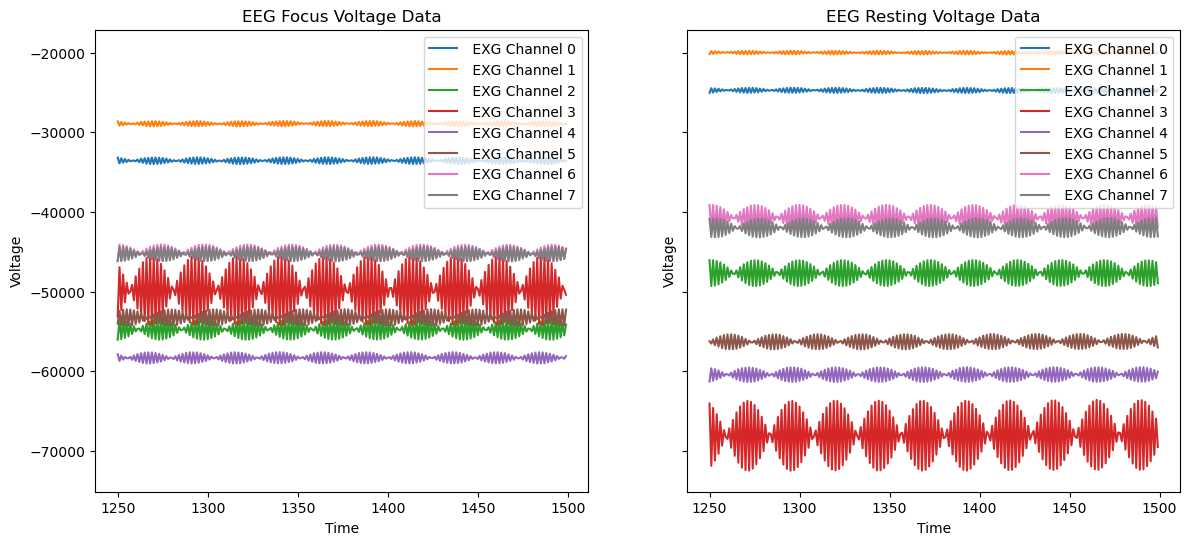

In [106]:
import matplotlib.pyplot as plt

channels = [datasets[1].iloc[0:125, :].columns][0]
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
for channel in channels:

    axes[0].plot(datasets[1].iloc[1250:1500, :].index, datasets[1].iloc[1250:1500, :][channel], label=channel)
    axes[1].plot(datasets[0].iloc[1250:1500, :].index, datasets[0].iloc[1250:1500, :][channel], label=channel)

axes[0].set_xlabel('Time')
axes[0].set_ylabel('Voltage')
axes[0].set_title('EEG Focus Voltage Data')
axes[0].legend()

axes[1].set_xlabel('Time')
axes[1].set_ylabel('Voltage')
axes[1].set_title('EEG Resting Voltage Data')
axes[1].legend()

### Filter

In [55]:
from scipy.signal import butter, filtfilt

def bandpass_filter(datasets):

    fs = 125 # sampling rate
    nyq = 0.5 * fs # Nyquist rate
    lowcut = 0.5 / nyq # lowpass
    highcut = 50 / nyq # highpass below 60 Hz to prevent environmental electrical interference
    filtered = []
    
    for dataset in datasets:
        
        b, a = butter(1, [lowcut, highcut], btype='band')
        filter = filtfilt(b, a, dataset, padlen=7)
        
        filtered.append(filter)

    return filtered

f_datasets = bandpass_filter(datasets)

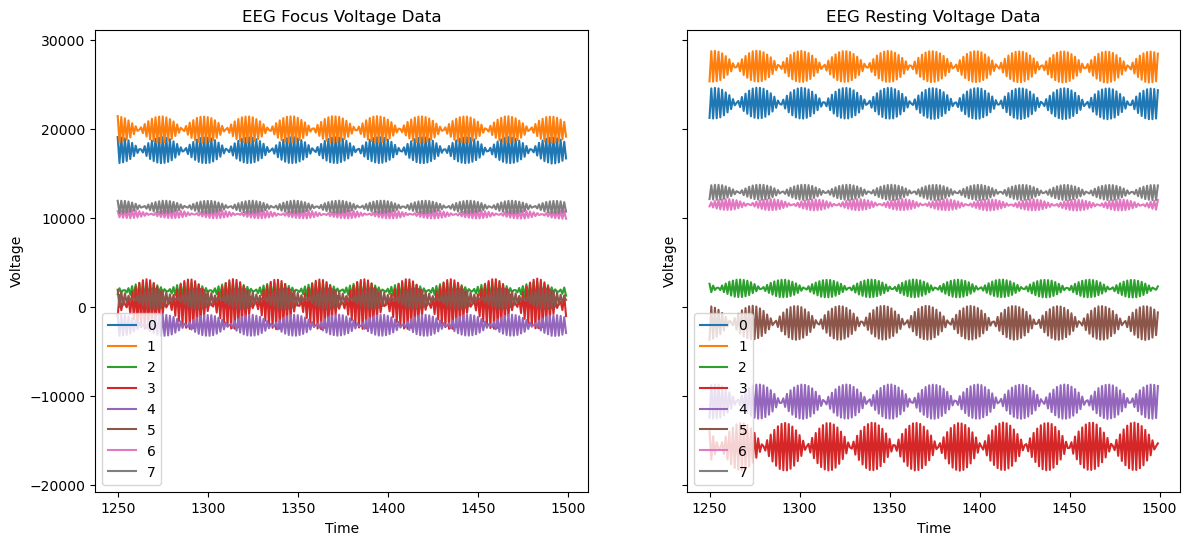

In [108]:
import matplotlib.pyplot as plt
f = pd.DataFrame(f_datasets[0])
f2 = pd.DataFrame(f_datasets[1])
channels = [f.iloc[0:125, :].columns][0]
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
for channel in channels:

    axes[0].plot(f2.iloc[1250:1500, :].index, f2.iloc[1250:1500, :][channel], label=channel)
    axes[1].plot(f.iloc[1250:1500, :].index, f.iloc[1250:1500, :][channel], label=channel)

axes[0].set_xlabel('Time')
axes[0].set_ylabel('Voltage')
axes[0].set_title('EEG Focus Voltage Data')
axes[0].legend()

axes[1].set_xlabel('Time')
axes[1].set_ylabel('Voltage')
axes[1].set_title('EEG Resting Voltage Data')
axes[1].legend()

plt.savefig('subplots_images.png')

### Epoch

In [57]:
def epoching(datasets):

    data = []
    for dataset in datasets:
        
        epoch_samples = 227
        num_epochs = len(dataset) // epoch_samples
        
        epochs = []
        
        for i in range(num_epochs):
            start_index = i * epoch_samples
            end_index = start_index + epoch_samples
            epoch = dataset[start_index:end_index]
            epochs.append(epoch)

        data.append(epochs)
        
    return data
    
epoch_datasets = epoching(f_datasets)

### PSD Feature Extraction

In [58]:
from scipy.signal import welch
def psd_vals(epochs):

    psd_datasets = []
    
    for dataset in epoch_datasets:
        
        brain_waves = {'Delta': [0.5, 4], 'Theta': [4, 8], 'Alpha': [8, 12], 'Beta': [12, 30], 'Gamma': [30, 100]}
        psd_per_band = {}
        fs = 125
        count = 0
        for epoch in dataset:
            
            for band, (start, end) in brain_waves.items():
                f, psd = welch(epoch.T, fs=fs, nperseg=len(epoch))
                band_indices = np.where((f>=start) & (f<end))[0]
                band_psd = np.mean(np.mean(psd[:, band_indices], axis=1))
                psd_per_band[count, band] = band_psd
        
            count += 1
        
        index = pd.MultiIndex.from_tuples(psd_per_band.keys())
        df = pd.DataFrame(psd_per_band.values(), index=index, columns=['Values'])
        df = df.unstack()
        df = df['Values']

        psd_datasets.append(df)
        
    return psd_datasets

psd_datasets = psd_vals(epoch_datasets)
psd_datasets[0]


,Alpha,Beta,Delta,Gamma,Theta
0,4.141130,2.132823,379.835892,46978.340222,7.178911
1,34.122017,9.481203,456.131891,43466.097877,81.991362
2,2.214825,1.737561,42.380732,43525.358751,8.794798
3,2.802052,2.231209,42.196767,43390.162979,10.668955
4,1.332171,2.526134,50.189892,43407.124757,10.121706
...,...,...,...,...,...
500,2.530607,1.020348,31.456339,32314.964702,8.367527
501,2.130624,0.960261,307.289512,32252.232165,3.721724
502,8.516488,1.525582,242.171283,30985.245930,27.583048
503,1.157527,0.845281,53.383732,32089.079781,11.660429


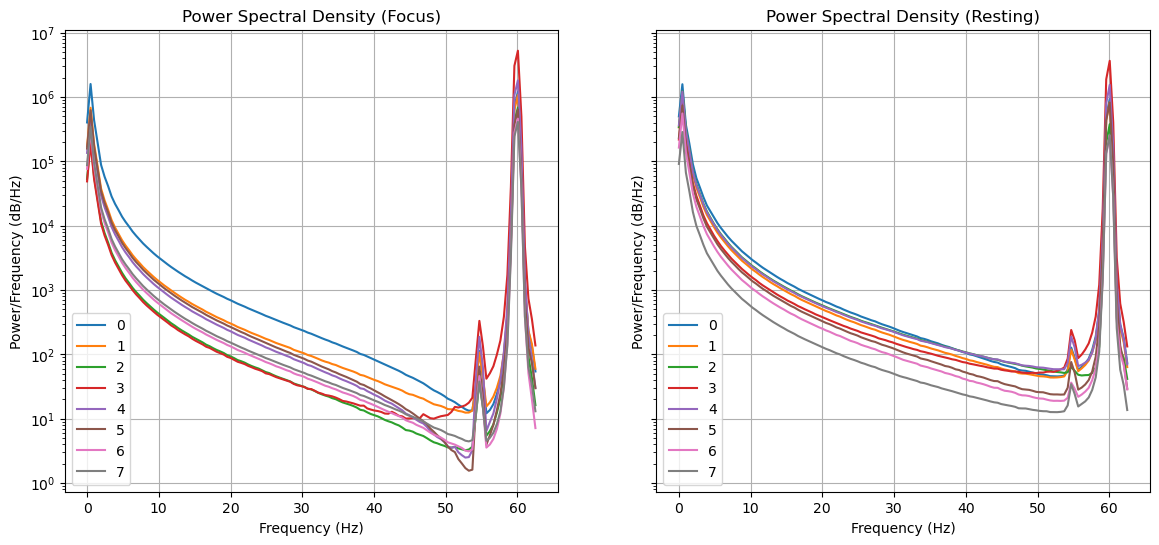

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

fs = 125  # Sample rate of EEG data in Hz
nperseg = 256  # Length of each segment in samples

# Compute the PSD for each channel
psd_values = []
psd_values2 = []
freq_values = []
freq_values2 = []
for channel in f.columns:
    freq, Pxx = welch(f[channel], fs=fs, nperseg=nperseg)
    freq2, Pxx2 = welch(f2[channel], fs=fs, nperseg=nperseg)
    freq_values.append(freq)
    freq_values2.append(freq2)
    psd_values.append(Pxx)
    psd_values2.append(Pxx2)

# Plot the PSD for each channel
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
for i, channel in enumerate(f.columns):
    axes[1].semilogy(freq_values[i], psd_values[i], label=channel)
    axes[0].semilogy(freq_values2[i], psd_values2[i], label=channel)
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Power/Frequency (dB/Hz)')
axes[1].set_title('Power Spectral Density (Resting)')
axes[1].legend()
axes[1].grid(True)

axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Power/Frequency (dB/Hz)')
axes[0].set_title('Power Spectral Density (Focus)')
axes[0].legend()
plt.legend()
axes[0].grid(True)

plt.savefig('PSDss.png')
plt.show()

### Fourier Coefficient Feature Extraction

In [60]:
def fourier_coef(epoch_dataset):

    fc_data = []
    for epoch_data in epoch_dataset:
        
        fc = []
        for epoch in epoch_data:
        
            fourier_coefficients_channel = np.fft.fft(epoch, axis=0)
            fc.append(fourier_coefficients_channel)
        
        import pandas as pd
        
        # Assuming fourier_coefficients_epochs contains Fourier coefficients for each epoch
        
        # Initialize an empty list to store DataFrames for each epoch
        epoch_dfs = []
        
        # Loop over each epoch's Fourier coefficients
        for i, epoch_coeffs in enumerate(fc):
            # Create a DataFrame for the current epoch's Fourier coefficients
            epoch_df = pd.DataFrame(epoch_coeffs, columns=[f'Channel_{j}_Fourier_Coefficient' for j in range(epoch_coeffs.shape[1])])
            # Add an 'Epoch' column to identify the epoch
            epoch_df['Epoch'] = i
            # Append the DataFrame to the list
            epoch_dfs.append(epoch_df)
        
        # Concatenate DataFrames for all epochs into a single DataFrame
        fourier_coefficients_df = pd.concat(epoch_dfs, ignore_index=True)
        
        # Now fourier_coefficients_df contains a DataFrame with Fourier coefficients for each epoch and channel
        # Group the DataFrame by the 'Epoch' column and calculate the mean for each group
        mean_coefficients_per_epoch = fourier_coefficients_df.groupby('Epoch').mean()

        fc_data.append(np.real(mean_coefficients_per_epoch))
    # Now mean_coefficients_per_epoch contains the mean of each column for every epoch
    return fc_data
    
fc_datasets = fourier_coef(epoch_datasets)
pd.DataFrame(fc_datasets[0])

,0,1,2,3,4,5,6,7
0,10614.289888,12764.770403,662.934696,-8927.376607,-6433.465594,-1373.908093,5344.273616,5966.382935
1,24520.872627,28726.258038,1456.833151,-18007.614937,-9074.925940,144.368702,11663.963039,13604.415275
2,24602.461862,28675.179061,2316.865709,-15732.879199,-8861.342635,-457.254880,12140.219724,13735.379801
3,23235.274406,27255.258962,3056.842762,-13469.206577,-10276.526176,-2238.418470,12137.770801,13146.971286
4,21597.948671,25633.577806,2884.406992,-13524.049626,-12107.372486,-3541.266990,11592.449858,12315.082015
...,...,...,...,...,...,...,...,...
500,88156.506952,58970.555374,16990.744385,10199.646646,32741.493178,40090.957848,34122.777208,42566.837996
501,87610.287093,58643.002158,16294.242563,7570.004045,30922.279439,39243.655448,33492.300761,42160.315530
502,88095.130346,59051.199011,16513.154546,7498.877841,30678.886023,39081.293688,33609.889584,42391.649778
503,88995.483949,59697.853708,17220.595645,9518.097233,31912.300659,39607.862129,34222.983556,42946.267544


### Merge

In [89]:
from sklearn.utils import shuffle

def conc(datasets):

    count = 0
    classes = []
    
    for data in datasets:

        y = pd.DataFrame(np.array(len(data) * [count]))
        classes.append(y)
        
        count += 1
        
    X = pd.concat([pd.DataFrame(datasets[0]), pd.DataFrame(datasets[1])], axis=0)
    y = pd.concat([classes[0], classes[1]], axis=0).rename(columns={0: 'Label'})
    #dataset = pd.concat([merge_X, merge_y], axis=1)
    
    return X, y

finished_dataset_psd, y_0 = conc(psd_datasets)
finished_dataset_fc, y_0 = conc(fc_datasets)

X_0 = pd.concat([finished_dataset_psd, finished_dataset_fc], axis=1)
finished_dataset = shuffle(pd.concat([X_0, y_0], axis=1))
finished_dataset.columns = finished_dataset.columns.astype(str)
X = finished_dataset.iloc[:, :13]
y = finished_dataset.iloc[:, 13]
finished_dataset['Alpha'].describe()

count    1.025000e+03
mean     2.671827e+03
std      8.398576e+04
min      5.512974e-01
25%      2.766038e+00
50%      4.205136e+00
75%      6.114870e+00
max      2.688720e+06
Name: Alpha, dtype: float64

### Feature Selection

[0.00056926 0.00524796 0.00265138 0.12289044 0.00068107 0.07677884
 0.15544609 0.13035572 0.13966767 0.170372   0.0658184  0.07790879
 0.05161238]


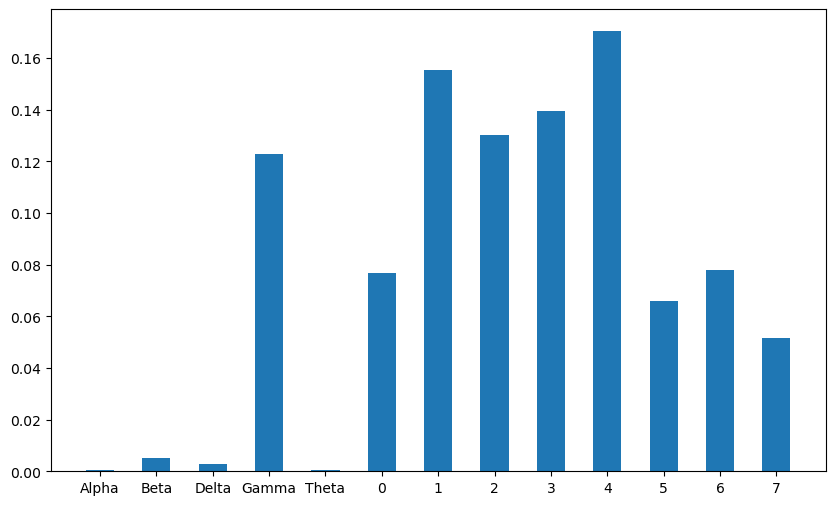

In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
rf = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf.fit(X_train, y_train)
features = X.columns
print(rf.feature_importances_)
plt.figure(figsize=(10,6))
plt.bar(features, rf.feature_importances_, width=0.5)
plt.savefig('feature_importances.png')
plt.show()

It appears that Gamma and Beta frequencies are most predictive out of the brain frequencies and Alpha, Delta, and Theta are the least predictive. It also appears like channels 2, 3, 4, and 5 are the most predictive out of the channel fourier coefficients. No need to get rid of any of these features since they all contribute well to prediction. If we had a dimensionality issue then we might remove alpha and theta bands.

### Training the Model

In [94]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

model = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
test_acc = accuracy_score(y_test, y_pred)
train_acc = accuracy_score(y_train, y_pred_train)
test_class = classification_report(y_test, y_pred)
train_class = classification_report(y_train, y_pred_train)
print("Training: ", train_class)
print("Testing: ", test_class)

Training:                precision    recall  f1-score   support

           0       1.00      1.00      1.00       456
           1       1.00      1.00      1.00       466

    accuracy                           1.00       922
   macro avg       1.00      1.00      1.00       922
weighted avg       1.00      1.00      1.00       922

Testing:                precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       1.00      1.00      1.00        54

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103



Achieved 100% accuracy. Ready to use the model on new incoming data.

### Classifier Function

In [ ]:
from scipy.signal import butter, filtfilt
def classify(data, model):
    
    def filtering(data):
        
        fs = 125
        nyq = 0.5 * fs
        low = 0.5 / nyq
        high = 50 / nyq
        b, a = butter(1, [low, high], btype='band')
        filter = filtfilt(b, a, data, padlen=7)
        return filter
    
    filtered_data = pd.DataFrame(filtering(data))
    
    from scipy.signal import welch
    def psd_vals(data):
    
        fs = 125
        psd_per_band = {}
        brain_waves = {'Delta': [0.5, 4], 'Theta': [4, 8], 'Alpha': [8, 12], 'Beta': [12, 30], 'Gamma': [30, 100]}
        for band, (start, end) in brain_waves.items():
            
            f, psd = welch(data.T, fs=fs, nperseg=len(data))
            indices = np.where((f >= start) & (f < end))[0]
            psd_per_band[band] = np.mean(psd[:, indices])
            
        psd_per_band = pd.DataFrame.from_dict(psd_per_band, orient='index')
        psd_per_band = psd_per_band.T

        psd_per_band = psd_per_band.sort_index(axis=1)
        psd_per_band['Delta'] = psd_per_band['Delta'].fillna(0)
        psd_per_band_na = psd_per_band
        psd_per_band = psd_per_band.drop('Delta', axis=1)
        return psd_per_band, psd_per_band_na
        
    psd_per_band, psd_per_band_na = psd_vals(filtered_data)
    psd_data = psd_per_band
    
    def fourier_coef(data):
    
        fs = 125
        
        fourier_coefficients_channel = (np.real(np.fft.fft(data, axis=0)).mean(axis=0)).reshape(1, -1)
    
        return fourier_coefficients_channel
    
    fc_data = fourier_coef(filtered_data)
    fc_data = pd.DataFrame(fc_data)
    
    dataframe = pd.concat([psd_data, fc_data], axis=1)
    dataframe.columns = dataframe.columns.astype(str)

    X = dataframe
    
    if model.predict(X) == np.array(0):

        z = 'Not Focused'

    elif model.predict(X) == np.array(1):

        z = 'Focused'

    return psd_per_band_na, z

### Real-Time Dashboard

In [1]:
app.layout = html.Div([
    html.Button('Stop', id='stop-button', n_clicks=0),
    dcc.Graph(id='focus-indicator', style={'height': '400px', 'width': '30%', 'display': 'inline-block'}),
    dcc.Graph(id='brainwave-bar', style={'height': '400px', 'width': '50%', 'display': 'inline-block'}),
    dcc.Interval(
        id='interval-component',
        interval=1*1000,  # in milliseconds
        n_intervals=0
    )
])

# Create board object outside the callback function
params = BrainFlowInputParams()
params.serial_port = "/dev/cu.usbserial-DM03H8BK"
board = BoardShim(0, params)  # assuming board_id = 0
board.prepare_session()
board.start_stream()
 
@app.callback(
    [Output('focus-indicator', 'figure'),
    Output('brainwave-bar', 'figure')],
    [Input('interval-component', 'n_intervals'),
     Input('stop-button', 'n_clicks')]
)

def update_focus_indicator(n, stop_clicks):
    if stop_clicks > 0:
        board.stop_stream()
        board.release_session()
        raise dash.exceptions.PreventUpdate

    # Retrieve data
    data = board.get_board_data()
    data = pd.DataFrame(data)
    data = data.T
    data = data.iloc[:, 1:9]
    print(data)
    p, z = classify(data, model)
    focus_state = "Focused" if z == 'Focused' else "Resting"
    focus_indicator = go.Scatter(x=[0], y=[0], mode='markers',
                                 marker={'size': 200, 'color': 'green' if focus_state == 'Focused' else 'white'})
    focus_indicator_fig = {
        'data': [go.Scatter(x=[0], y=[0], mode='markers', marker={'size': 210, 'color': 'black'}), focus_indicator],
        'layout': {'title': 'Focus Indicator',
                   'xaxis': {'visible': False, 'range': [-1, 1]},
                   'yaxis': {'visible': False, 'range': [-1, 1]},
                   'showlegend': False}
    }

    # Create bar plot for brainwave data
    brainwave_bar = go.Figure()
    brainwave_bar.add_trace(go.Bar(
        x=['Delta', 'Theta', 'Alpha'],
        y=p.values.flatten(),
        marker_color=['red', 'blue', 'green']
    ))
    brainwave_bar.update_layout(title='Brainwave Activity', xaxis_title='Frequency Band', yaxis_title='Power')

    return focus_indicator_fig, brainwave_bar

if __name__ == '__main__':
    #app.run_server(debug=True)


SyntaxError: incomplete input (3120479899.py, line 335)

## Discussion

### Neural Data Analysis Discussion

Adding all the resting datasets together and the focused datasets together, the signals from each channel after apply a filter with a 0.5 lowpass and 50 highpass are as follows:

![Sample Plot](subplots_images.png)


We see that it appears that theres a clear voltage difference in 250 samples of data between the focused state and the resting state. Channels 0 and 1 have a lower voltage than its resting counterparts. Then channels 3 and 4 are significantly higher in the focus plot than its resting counterpart. Channels 0 and 1 measure the frontal cortex which is related to attention and planning, to which it appears that focus state is followed by a distinct reduction in voltage. Meanwhile channel 3 is located in the parietal lobe and channel 4 is located close to the occipital lobe. Both have an increase in voltage, suggesting these brain regions may also be affected in the focus state. Meanwhile, channels 2, 5, 6, and 7 in regions in parietal and occipital regions appear to remain the same. This could mean that their specific subsections are not implicated in focus neural generators. The following is a demonstration of the OpenBCI 16 channel system (Note: my channels are depicted as indexed at 0 while theirs is at 1):

![Image Alt Text](images.jpeg)

Now, not much can be gathered from a simple voltage vs time plot depicting each channel. Therefore, especially when understanding focus state, we must extract a power spectrum from the data to truly capture the brain frequencies that are differing between focus state and resting state. The following reveals such power spectrum:

![Sample Plot](PSDss.png)

As we can see, the power seems to decrease as frequency increases, which is typical as delta, theta, and alpha bands have the most power. However it appears that power decreases at a much faster rate at around 8 Hz for the focus state and achieves a significantly lower power between 20 and 50 Hz, compared to the resting state. This suggests that the beta band and the gamma band appear to indicate increased synchronization and coherence in neural activity, which are associated with focus cognitive processes. So now, which bands have the most predictive power towards classifying focus and resting? Also, which channel's fourier coefficients are most predictive for classification too?

![Sample Plot](feature_importances.png)

It appears that Gamma bands and Beta bands are the highest importance from the brain frequency bands, which backs up our previous discussion of power and how the last bands demonstrate a significantly difference in power between focus and resting states. It is also interesting that Delta band has somewhat of a close importance to Beta band, and looking back at the Power Spectrum plot we see that there is more of faster rate in reduction of power over increasing frequency for focus state which could be what is differentiating this feature and making it slightly more important.
It also appears that the fourier coefficients acquired from channel 1, 2, 3, and 4 are the most predictive of focus state. This could be because channel 1 is acquiring data from the frontal cortex which is absolutely important in attention. Then 2 and 3 are in the parietal cortex area, also suggesting there might be a focus neural generator near there. Lastly channel 4 could be receiving data from the occipital cortex for understanding what I am reading in the experiment. Now how well does our Random Forest Classifier fit our data and generalize to outside data.

### Machine Learning Discussion

In [122]:
print("Training: ", train_class)
print("Testing: ", test_class)

Training:                precision    recall  f1-score   support

           0       1.00      1.00      1.00       456
           1       1.00      1.00      1.00       466

    accuracy                           1.00       922
   macro avg       1.00      1.00      1.00       922
weighted avg       1.00      1.00      1.00       922

Testing:                precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       1.00      1.00      1.00        54

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103



An accuracy score of 100% was achieved using the Random Forest Classifier. The Random Forest model is especially valuable in EEG data classification because of its ability to capture nonlinear relationships. Random Forests are also ensemble models, meaning they combine predictions of many decision trees on different subsets of data, thereby improving generalization performance. Due to this robustness, they are able to ignore noise and only utilize data that is informative to the task.